In [1]:
# general tools
import time
import random
# crawling
import selenium
from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
# DataProcessing
import pandas as pd
import geopandas as gpd
import geoplot
import shapely
import matplotlib.pyplot as plt
%matplotlib notebook
# visualizatoin
import keplergl

In [2]:
def to_multipolygon(input_df):
    
    df = input_df.copy()
    geo_type = [df.iloc[_, 1].type for _ in range(len(df))]
    new_geometry = []
    
    for i in range(len(geo_type)):
        if geo_type[i] == 'MultiPolygon':
            new_geometry.append(df.geometry.iloc[i])
        elif geo_type[i] == 'Polygon':
            new_geometry.append(shapely.geometry.multipolygon.MultiPolygon([df['geometry'].iloc[i]]))
        else:
            new_geometry.append([shapely.geometry.multipolygon.MultiPolygon()])
    df.geometry = new_geometry
    
    return df


## Crawling

In [3]:
def extract_houses_links(
    web_driver,
    link_template=r'https://www.funda.nl/koop/amsterdam/0-375000/appartement/2+slaapkamers/bouwperiode-2001-2010/bouwperiode-na-2010',
    verbose=False):
    
    # template link
    if link_template[-1] == r'/':
        link_template += r'p@PAGE_COUNTER@/'
    else:
        link_template += r'/p@PAGE_COUNTER@/'
        
    if verbose:
        print(link_template)

    # Iterate over all elements with the tag name 'div'
    data = []
    results_counter = 0
    page_counter = 1
    
    while True:
        link = link_template.replace('@PAGE_COUNTER@', str(page_counter))
    
        web_driver.get(link)
        time.sleep(random.randint(2, 7))
        sub_counter = 0
        
        for i in web_driver.find_elements_by_tag_name('div'):
            result_content = i.get_attribute('class')
            # if the class name is 'search-result-content' we are on a good track
            if result_content == 'search-result-content':
                x = i.find_element_by_tag_name('a')
                if verbose:
                    print(x.text)
                    #print(x.tag_name)
                    print(x.get_attribute('href'))
                    print('------ %s' % results_counter)
                data.append([x.text, x.get_attribute('href')])

                results_counter += 1
                sub_counter += 1
    
        # control errors
        if sub_counter == 0:
            print('Something happened')
            break

        page_counter += 1
        
    return pd.DataFrame(data, columns=['Name', 'Link'])

In [17]:
def parse_property_info(link, web_driver):
    
    # access to link
    web_driver.get(link)

    # click button
    time.sleep(random.randint(2, 5))
    try:
        more_info_button = web_driver.find_element_by_class_name('object-kenmerken-open-button')
        if more_info_button.text != '': 
            more_info_button.click()
    except Exception as e:
        #print('>%s<' % more_info_button.text)
        print('Button not found')
        print(e)
    
    #
    list_of_needed_elements = ['Vraagprijs', 'Vraagprijs per m²', 'Aangeboden sinds', 'Status', 'Aanvaarding',
                               'Bijdrage VvE', 'Soort appartement', 'Soort bouw', 'Bouwjaar', 'Toegankelijkheid',
                               'Soort dak', 'Keurmerken', 'Wonen', 'Inhoud', 'Aantal kamers', 'Aantal badkamers', 
                              'Badkamervoorzieningen', 'Aantal woonlagen', 'Gelegen op', 'Voorzieningen',
                               'Energielabel', 'Isolatie', 'Verwarming', 'Soort garage']
    info_dict = {}
    
    for item in web_driver.find_elements_by_tag_name('dl'):
        #print('--------------------------')
        #print('---- %s ------' % item.text)
        labels_elements = item.find_elements_by_tag_name('dt')
        values_elements = item.find_elements_by_tag_name('dd')
        for i in range(len(labels_elements)):
            if labels_elements[i].text in list_of_needed_elements:
                info_dict.update({labels_elements[i].text: [values_elements[i].text]})
                #print('%s : %s' % (labels_elements[i].text, values_elements[i].text))
            #print(item2.text)
        #print(item.text)
        #print('--------------------------')
    ## Add postal code
    # get postal code

    postal_code = web_driver.find_element_by_class_name('object-header__address-city').text

    
    info_dict.update({'Postal Code': [postal_code[:7].replace(' ', '')]})
    
    # Add link
    info_dict.update({'Link': [link]})
    
    df = pd.DataFrame.from_dict(info_dict, orient='columns')
    return df

In [ ]:
def get_coordinates(postal_code, web_driver, db_file='pc_coordinates_netherlands.csv'):
    postal_code = postal_code.upper()
    df = pd.read_csv(db_file)
    #print(postal_code)
    if postal_code in df['PostalCode'].unique().tolist():
        #print(df['PostalCode'].unique().tolist())
        [_, lat, long] = df[df['PostalCode'] == postal_code].values[0]
        lat = float(lat)
        long = float(long)
    else:
        web_driver.get('https://www.latlong.net/convert-address-to-lat-long.html')
        time.sleep(0)

        web_driver.find_element_by_tag_name('input').send_keys('%s Netherlands' % postal_code)
        time.sleep(0.1)
        web_driver.find_element_by_tag_name('button').click()
        time.sleep(4)
        coordinates = web_driver.find_element_by_class_name('coordinatetxt').text

        lat, long = coordinates.replace('(', '').replace(')', '').replace(' ', '').split(',')
        lat = float(lat)
        long = float(long)

        df = df.append({'PostalCode': postal_code, 'Latitude': lat, 'Longitude': long}, ignore_index=True)
        df.to_csv(db_file, index=False)

    return lat, long

In [9]:
# open web browser driver
p = r'/usr/local/bin/chromedriver'
web_driver = webdriver.Chrome(executable_path=p)

In [10]:
search_template_link = 'https://www.funda.nl/'
web_driver.get(search_template_link)

In [334]:
web_driver.close()

In [11]:
#search_template_link = r'https://www.funda.nl/koop/amsterdam/0-375000/appartement/2+slaapkamers/bouwperiode-2001-2010/bouwperiode-na-2010/p@PAGE_COUNTER@/'
#search_template_link = r'https://www.funda.nl/koop/amsterdam/50000-400000/appartement/2+kamers/bouwperiode-2001-2010/bouwperiode-na-2010/+10km/'
search_template_link = r'https://www.funda.nl/koop/amsterdam/50+woonopp/0-400000/appartement/2+slaapkamers/'
df_links = extract_houses_links(web_driver, link_template=search_template_link)
df_links.head()

Something happened


,Name,Link
0,Talbotstraat 207,https://www.funda.nl/koop/amsterdam/appartemen...
1,Burgemeester Hogguerstraat 777,https://www.funda.nl/koop/amsterdam/appartemen...
2,Laing's Nekstraat 36 I,https://www.funda.nl/koop/amsterdam/appartemen...
3,Hellenburg 11,https://www.funda.nl/koop/amsterdam/appartemen...
4,David Blesstraat 6 hs,https://www.funda.nl/koop/amsterdam/appartemen...


In [12]:
len(df_links)

519

In [21]:
df_list = []
c = 0
ok = False

for i_link in df_links['Link'].tolist():

    print(i_link)

    df_i = parse_property_info(link=i_link, web_driver=web_driver)
    df_list.append(df_i)


https://www.funda.nl/koop/amsterdam/appartement-41420853-talbotstraat-207/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41420751-burgemeester-hogguerstraat-777/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-87884381-laing-s-nekstraat-36-i/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41428710-hellenburg-11/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-87882314-david-blesstraat-6-hs/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-87857893-griseldestraat-28-2/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41490934-ijburglaan-999/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41490906-catharina-boudewijnshof-79/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-87827597-jisperveldstraat-237/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-414695

https://www.funda.nl/koop/amsterdam/appartement-40276053-madurastraat-77-d/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-40256506-rustenburgerstraat-144-a/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-40136894-alblasstraat-60-h/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-40199023-burgemeester-cramergracht-111/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-40064040-sierplein-61/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41499098-jacob-van-lennepkade-352-i/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41475803-nageljongenstraat-115/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41469299-ladogameerhof-171/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-41469561-ijdoornlaan-1449-a/?navigateSource=resultlist
https://www.funda.nl/koop/amsterdam/appartement-878230

https://www.funda.nl/koop/amsterdam/appartement-86669967-eva-besnyostraat-385/?navigateSource=resultlist
Button not found
Message: no such element: Unable to locate element: {"method":"css selector","selector":".object-kenmerken-open-button"}
  (Session info: chrome=77.0.3865.120)

https://www.funda.nl/koop/amsterdam/appartement-86574448-osdorper-ban-185/?navigateSource=resultlist
Button not found
Message: no such element: Unable to locate element: {"method":"css selector","selector":".object-kenmerken-open-button"}
  (Session info: chrome=77.0.3865.120)

https://www.funda.nl/koop/amsterdam/appartement-86427701-renswoudestraat-16/?navigateSource=resultlist
Button not found
Message: no such element: Unable to locate element: {"method":"css selector","selector":".object-kenmerken-open-button"}
  (Session info: chrome=77.0.3865.120)



In [ ]:
web_driver.close()

In [22]:
len(df_list)

519

### DataProcessing

In [23]:
df_info = pd.concat(df_list, axis=0, sort=False).fillna('-')
df_info.head()

,Vraagprijs,Vraagprijs per m²,Aangeboden sinds,Status,Aanvaarding,Bijdrage VvE,Soort appartement,Soort bouw,Bouwjaar,Soort dak,...,Gelegen op,Voorzieningen,Energielabel,Isolatie,Verwarming,Postal Code,Link,Keurmerken,Toegankelijkheid,Soort garage
0,€ 400.000 k.k.,€ 4.396,11 oktober 2019,Beschikbaar,In overleg,€ 128 per maand,Galerijflat (appartement),Bestaande bouw,2006,Plat dak bedekt met bitumineuze dakbedekking,...,3e woonlaag,Elektra,A Wat betekent dit?,Geen isolatie,Stadsverwarming,1087DM,https://www.funda.nl/koop/amsterdam/appartemen...,-,-,-
0,€ 300.000 k.k.,€ 3.846,12 oktober 2019,Beschikbaar,In overleg,€ 172 per maand,Bovenwoning (appartement),Bestaande bouw,1964,Plat dak bedekt met bitumineuze dakbedekking,...,15e woonlaag,TV kabel en lift,E Wat betekent dit?,Dubbel glas,Blokverwarming,1064EB,https://www.funda.nl/koop/amsterdam/appartemen...,-,-,-
0,€ 325.000 k.k.,€ 6.373,12 oktober 2019,Beschikbaar,In overleg,€ 106 per maand,Tussenverdieping (appartement),Bestaande bouw,1915,Zadeldak bedekt met pannen en bitumineuze dakb...,...,2e woonlaag,TV kabel,D Wat betekent dit?,Dubbel glas,Cv-ketel,1092GX,https://www.funda.nl/koop/amsterdam/appartemen...,Energie Prestatie Advies,-,-
0,€ 375.000 k.k.,€ 4.688,11 oktober 2019,Beschikbaar,In overleg,€ 283 per maand,Bovenwoning (appartement),Bestaande bouw,1961,Plat dak bedekt met bitumineuze dakbedekking,...,2e woonlaag,Elektra,C Wat betekent dit?,Dubbel glas,Stadsverwarming,1082GP,https://www.funda.nl/koop/amsterdam/appartemen...,-,-,-
0,€ 325.000 k.k.,€ 5.909,11 oktober 2019,Beschikbaar,In overleg,€ 85 per maand,Benedenwoning (appartement),Bestaande bouw,1923,Mansarde dak bedekt met bitumineuze dakbedekki...,...,Begane grond,-,E Wat betekent dit?,Volledig geïsoleerd,Cv-ketel,1073LA,https://www.funda.nl/koop/amsterdam/appartemen...,-,-,-


In [79]:
df_info.to_csv('df_info.csv', index=False)
df_links.to_csv('df_links.csv', index=False)

In [119]:
df_info = pd.read_csv('df_info.csv')
df_links = pd.read_csv('df_links.csv')

In [120]:
df = df_links.merge(df_info, on='Link')
df

,Name,Link,Vraagprijs,Vraagprijs per m²,Aangeboden sinds,Status,Aanvaarding,Bijdrage VvE,Soort appartement,Soort bouw,...,Aantal woonlagen,Gelegen op,Voorzieningen,Energielabel,Isolatie,Verwarming,Postal Code,Keurmerken,Toegankelijkheid,Soort garage
0,Talbotstraat 207,https://www.funda.nl/koop/amsterdam/appartemen...,€ 400.000 k.k.,€ 4.396,11 oktober 2019,Beschikbaar,In overleg,€ 128 per maand,Galerijflat (appartement),Bestaande bouw,...,1 woonlaag,3e woonlaag,Elektra,A Wat betekent dit?,Geen isolatie,Stadsverwarming,1087DM,-,-,-
1,Burgemeester Hogguerstraat 777,https://www.funda.nl/koop/amsterdam/appartemen...,€ 300.000 k.k.,€ 3.846,12 oktober 2019,Beschikbaar,In overleg,€ 172 per maand,Bovenwoning (appartement),Bestaande bouw,...,1 woonlaag,15e woonlaag,TV kabel en lift,E Wat betekent dit?,Dubbel glas,Blokverwarming,1064EB,-,-,-
2,Laing's Nekstraat 36 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 6.373,12 oktober 2019,Beschikbaar,In overleg,€ 106 per maand,Tussenverdieping (appartement),Bestaande bouw,...,1 woonlaag,2e woonlaag,TV kabel,D Wat betekent dit?,Dubbel glas,Cv-ketel,1092GX,Energie Prestatie Advies,-,-
3,Hellenburg 11,https://www.funda.nl/koop/amsterdam/appartemen...,€ 375.000 k.k.,€ 4.688,11 oktober 2019,Beschikbaar,In overleg,€ 283 per maand,Bovenwoning (appartement),Bestaande bouw,...,1 woonlaag,2e woonlaag,Elektra,C Wat betekent dit?,Dubbel glas,Stadsverwarming,1082GP,-,-,-
4,David Blesstraat 6 hs,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 5.909,11 oktober 2019,Beschikbaar,In overleg,€ 85 per maand,Benedenwoning (appartement),Bestaande bouw,...,1 woonlaag,Begane grond,-,E Wat betekent dit?,Volledig geïsoleerd,Cv-ketel,1073LA,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,Rijnstraat 62 4,https://www.funda.nl/koop/amsterdam/appartemen...,€ 339.000 k.k.,€ 5.557,6+ maanden,-,-,-,Bovenwoning (appartement),Bestaande bouw,...,-,-,-,Niet verplicht,-,-,1079HJ,-,-,-
515,Giessenburg 6,https://www.funda.nl/koop/amsterdam/appartemen...,€ 349.000 k.k.,€ 5.288,3 maanden,-,-,-,Galerijflat (appartement),Bestaande bouw,...,-,-,-,-,-,-,1082CW,-,-,-
516,Eva Besnyöstraat 385,https://www.funda.nl/koop/amsterdam/appartemen...,€ 395.000 k.k.,€ 4.877,3 maanden,-,-,-,Galerijflat (appartement),Bestaande bouw,...,-,-,-,-,-,-,1087LG,-,-,-
517,Osdorper Ban 185,https://www.funda.nl/koop/amsterdam/appartemen...,€ 240.000 k.k.,€ 3.529,6+ maanden,-,-,-,Galerijflat (appartement),Bestaande bouw,...,-,-,-,"E 2,24 Wat betekent dit?",-,-,1068LV,-,-,-


In [121]:
len(df['Postal Code'].unique().tolist())

450

In [118]:
lat_long_web_driver = webdriver.Chrome(executable_path=p)
lat_long_web_driver.get('https://www.latlong.net/convert-address-to-lat-long.html')

In [133]:
# Collecting coordinates of postal codes
data = []
for postal_code in df['Postal Code'].unique().tolist():
    print(postal_code)
    lat, long = get_coordinates(postal_code, web_driver=lat_long_web_driver)
    new_data = [postal_code, lat, long]
    print(new_data)
    data.append(new_data)

1087DM
['1087DM', 52.35794, 4.99516]
1064EB
['1064EB', 52.3725, 4.83004]
1092GX
['1092GX', 52.35506, 4.92386]
1082GP
['1082GP', 52.32638, 4.87948]
1073LA
['1073LA', 52.34953, 4.9021300000000005]
1055AX
['1055AX', 52.37673, 4.84893]
1087EN
['1087EN', 52.36169, 4.9832800000000015]
1064PG
['1064PG', 52.37806, 4.81016]
1024AL
['1024AL', 52.39866, 4.95118]
1066RA
['1066RA', 52.3457, 4.80841]
1069BX
['1069BX', 52.35484, 4.791919999999998]
1069ZR
['1069ZR', 52.36047, 4.791869999999999]
1025WV
['1025WV', 52.39709000000001, 4.94165]
1061VX
['1061VX', 52.363209999999995, 4.84049]
1057SX
['1057SX', 52.369, 4.85398]
1068ZH
['1068ZH', 52.3651, 4.80165]
1067XX
['1067XX', 52.37749, 4.80318]
1055DE
['1055DE', 52.37915, 4.85431]
1069TS
['1069TS', 52.35674, 4.78926]
1067HD
['1067HD', 52.38156, 4.79772]
1025AM
['1025AM', 52.40187, 4.94735]
1097BN
['1097BN', 52.34754, 4.94066]
1069EE
['1069EE', 52.35674, 4.78926]
1035BB
['1035BB', 52.41901, 4.8860199999999985]
1103GZ
['1103GZ', 52.32257, 4.97685]
1068PM
[

['1055GR', 52.37867, 4.85198]
1055SN
['1055SN', 52.3778, 4.854419999999998]
1025TX
['1025TX', 52.39918, 4.93041]
1098TS
['1098TS', 52.35196, 4.94572]
1034AB
['1034AB', 52.408157, 4.913368]
1087KH
['1087KH', 52.355779999999996, 4.9969800000000015]
1067DZ
['1067DZ', 52.38048, 4.80393]
1064EJ
['1064EJ', 52.3725, 4.83004]
1024PX
['1024PX', 52.39497, 4.94643]
1060TX
['1060TX', 52.35394, 4.80995]
1082JH
['1082JH', 52.32763, 4.87305]
1104VA
['1104VA', 52.313979, 4.981067]
1068JA
['1068JA', 52.35684000000001, 4.81441]
1098SN
['1098SN', 52.35124, 4.94275]
1065HD
['1065HD', 52.354240000000004, 4.82385]
1051EL
['1051EL', 52.38334, 4.87221]
1082TW
['1082TW', 52.33383, 4.87844]
1024LD
['1024LD', 52.39088, 4.95743]
1031HZ
['1031HZ', 52.393771, 4.9010110000000005]
1058GX
['1058GX', 52.35939000000001, 4.85113]
1087Am
['1087Am', 43.60763, -90.19658]
1087EK
['1087EK', 52.355779999999996, 4.9969800000000015]
1033ZB
['1033ZB', 52.41714, 4.88485]
1056SK
['1056SK', 52.37127, 4.8533800000000005]
1033DL
['103

In [135]:
lat_long_web_driver.close()

In [136]:
len(set(df['Postal Code'].unique().tolist()) - set(pd.read_csv('pc_coordinates_netherlands.csv')['PostalCode'].unique().tolist()))

3

In [137]:
#coordinates_df = pd.read_csv('postal_codes_coordinates.csv')
coordinates_df = pd.read_csv('pc_coordinates_netherlands.csv')
coordinates_df.head()

,PostalCode,Latitude,Longitude
0,1506TX,52.437721,4.81624
1,1506DW,52.441280,4.81900
2,1506GM,52.447140,4.81923
3,1506GB,52.447140,4.81923
4,1506DV,52.441280,4.81900


In [138]:
df['Postal Code Generic'] = df['Postal Code'].str[:4]
df['Postal Code Generic'] = df['Postal Code Generic'].astype(int)

In [139]:
df = df.merge(coordinates_df[['PostalCode', 'Latitude', 'Longitude']], left_on='Postal Code', right_on='PostalCode')
df.fillna(0, inplace=True)
df.head(10)

,Name,Link,Vraagprijs,Vraagprijs per m²,Aangeboden sinds,Status,Aanvaarding,Bijdrage VvE,Soort appartement,Soort bouw,...,Isolatie,Verwarming,Postal Code,Keurmerken,Toegankelijkheid,Soort garage,Postal Code Generic,PostalCode,Latitude,Longitude
0,Talbotstraat 207,https://www.funda.nl/koop/amsterdam/appartemen...,€ 400.000 k.k.,€ 4.396,11 oktober 2019,Beschikbaar,In overleg,€ 128 per maand,Galerijflat (appartement),Bestaande bouw,...,Geen isolatie,Stadsverwarming,1087DM,-,-,-,1087,1087DM,52.35794,4.99516
1,Burgemeester Hogguerstraat 777,https://www.funda.nl/koop/amsterdam/appartemen...,€ 300.000 k.k.,€ 3.846,12 oktober 2019,Beschikbaar,In overleg,€ 172 per maand,Bovenwoning (appartement),Bestaande bouw,...,Dubbel glas,Blokverwarming,1064EB,-,-,-,1064,1064EB,52.37250,4.83004
2,Laing's Nekstraat 36 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 6.373,12 oktober 2019,Beschikbaar,In overleg,€ 106 per maand,Tussenverdieping (appartement),Bestaande bouw,...,Dubbel glas,Cv-ketel,1092GX,Energie Prestatie Advies,-,-,1092,1092GX,52.35506,4.92386
3,Laing's Nekstraat 40 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 315.000 k.k.,€ 6.300,6+ maanden,Verkocht onder voorbehoud,In overleg,€ 106 per maand,Portiekwoning (appartement),Bestaande bouw,...,Dubbel glas,Cv-ketel,1092GX,Energie Prestatie Advies,-,-,1092,1092GX,52.35506,4.92386
4,Hellenburg 11,https://www.funda.nl/koop/amsterdam/appartemen...,€ 375.000 k.k.,€ 4.688,11 oktober 2019,Beschikbaar,In overleg,€ 283 per maand,Bovenwoning (appartement),Bestaande bouw,...,Dubbel glas,Stadsverwarming,1082GP,-,-,-,1082,1082GP,52.32638,4.87948
5,David Blesstraat 6 hs,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 5.909,11 oktober 2019,Beschikbaar,In overleg,€ 85 per maand,Benedenwoning (appartement),Bestaande bouw,...,Volledig geïsoleerd,Cv-ketel,1073LA,-,-,-,1073,1073LA,52.34953,4.90213
6,Griseldestraat 28 2,https://www.funda.nl/koop/amsterdam/appartemen...,€ 300.000 k.k.,€ 5.357,2 weken,Beschikbaar,In overleg,€ 50 per maand,Bovenwoning (appartement met open portiek),Bestaande bouw,...,Dubbel glas,Cv-ketel,1055AX,-,-,-,1055,1055AX,52.37673,4.84893
7,IJburglaan 999,https://www.funda.nl/koop/amsterdam/appartemen...,€ 395.000 k.k.,€ 3.950,2 weken,Beschikbaar,In overleg,€ 124 per maand,Galerijflat (appartement),Bestaande bouw,...,Dubbel glas en volledig geïsoleerd,"Stadsverwarming, gehele vloerverwarming en war...",1087EN,-,Toegankelijk voor gehandicapten en toegankelij...,-,1087,1087EN,52.36169,4.98328
8,IJburglaan 851,https://www.funda.nl/koop/amsterdam/appartemen...,€ 375.000 k.k.,€ 3.989,12 oktober 2019,Beschikbaar,In overleg,€ 156 per maand,Bovenwoning (appartement),Bestaande bouw,...,Volledig geïsoleerd,Stadsverwarming,1087EN,-,-,Parkeerkelder en parkeerplaats,1087,1087EN,52.36169,4.98328
9,IJburglaan 1051,https://www.funda.nl/koop/amsterdam/appartemen...,€ 385.000 k.k.,€ 4.096,3 maanden,Verkocht onder voorbehoud,In overleg,€ 118 per maand,Bovenwoning (appartement),Bestaande bouw,...,Volledig geïsoleerd,Stadsverwarming,1087EN,-,-,-,1087,1087EN,52.36169,4.98328


In [140]:
df['Vraagprijs'].str[-5:].unique()

array([' k.k.', '.o.n.'], dtype=object)

In [141]:
def get_integer(my_str):
    my_str = my_str.replace('²', '')
    try:
        v = int(''.join(list(filter(str.isdigit, my_str))))
    except ValueError:
        v = 0
    return v

In [142]:
def get_sale_type(my_str):
    v = my_str[-5:]
    if v == ' k.k.':
        r = 'K.K.'
    elif v == '.o.n.':
        r = 'V.O.N.'
    else:
        r = '-'
    return r

In [143]:
# Correct price
df['Price'] = df['Vraagprijs'].apply(lambda x: get_integer(x))
df['Sale type'] = df['Vraagprijs'].apply(lambda x: get_sale_type(x))
df['Price per m2'] = df['Vraagprijs per m²'].apply(lambda x: get_integer(x))
# Correct surface
df['Surface'] = df['Wonen'].apply(lambda x: get_integer(x))

In [144]:
df.head(10)

,Name,Link,Vraagprijs,Vraagprijs per m²,Aangeboden sinds,Status,Aanvaarding,Bijdrage VvE,Soort appartement,Soort bouw,...,Toegankelijkheid,Soort garage,Postal Code Generic,PostalCode,Latitude,Longitude,Price,Sale type,Price per m2,Surface
0,Talbotstraat 207,https://www.funda.nl/koop/amsterdam/appartemen...,€ 400.000 k.k.,€ 4.396,11 oktober 2019,Beschikbaar,In overleg,€ 128 per maand,Galerijflat (appartement),Bestaande bouw,...,-,-,1087,1087DM,52.35794,4.99516,400000,K.K.,4396,91
1,Burgemeester Hogguerstraat 777,https://www.funda.nl/koop/amsterdam/appartemen...,€ 300.000 k.k.,€ 3.846,12 oktober 2019,Beschikbaar,In overleg,€ 172 per maand,Bovenwoning (appartement),Bestaande bouw,...,-,-,1064,1064EB,52.37250,4.83004,300000,K.K.,3846,78
2,Laing's Nekstraat 36 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 6.373,12 oktober 2019,Beschikbaar,In overleg,€ 106 per maand,Tussenverdieping (appartement),Bestaande bouw,...,-,-,1092,1092GX,52.35506,4.92386,325000,K.K.,6373,51
3,Laing's Nekstraat 40 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 315.000 k.k.,€ 6.300,6+ maanden,Verkocht onder voorbehoud,In overleg,€ 106 per maand,Portiekwoning (appartement),Bestaande bouw,...,-,-,1092,1092GX,52.35506,4.92386,315000,K.K.,6300,50
4,Hellenburg 11,https://www.funda.nl/koop/amsterdam/appartemen...,€ 375.000 k.k.,€ 4.688,11 oktober 2019,Beschikbaar,In overleg,€ 283 per maand,Bovenwoning (appartement),Bestaande bouw,...,-,-,1082,1082GP,52.32638,4.87948,375000,K.K.,4688,80
5,David Blesstraat 6 hs,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 5.909,11 oktober 2019,Beschikbaar,In overleg,€ 85 per maand,Benedenwoning (appartement),Bestaande bouw,...,-,-,1073,1073LA,52.34953,4.90213,325000,K.K.,5909,55
6,Griseldestraat 28 2,https://www.funda.nl/koop/amsterdam/appartemen...,€ 300.000 k.k.,€ 5.357,2 weken,Beschikbaar,In overleg,€ 50 per maand,Bovenwoning (appartement met open portiek),Bestaande bouw,...,-,-,1055,1055AX,52.37673,4.84893,300000,K.K.,5357,56
7,IJburglaan 999,https://www.funda.nl/koop/amsterdam/appartemen...,€ 395.000 k.k.,€ 3.950,2 weken,Beschikbaar,In overleg,€ 124 per maand,Galerijflat (appartement),Bestaande bouw,...,Toegankelijk voor gehandicapten en toegankelij...,-,1087,1087EN,52.36169,4.98328,395000,K.K.,3950,100
8,IJburglaan 851,https://www.funda.nl/koop/amsterdam/appartemen...,€ 375.000 k.k.,€ 3.989,12 oktober 2019,Beschikbaar,In overleg,€ 156 per maand,Bovenwoning (appartement),Bestaande bouw,...,-,Parkeerkelder en parkeerplaats,1087,1087EN,52.36169,4.98328,375000,K.K.,3989,94
9,IJburglaan 1051,https://www.funda.nl/koop/amsterdam/appartemen...,€ 385.000 k.k.,€ 4.096,3 maanden,Verkocht onder voorbehoud,In overleg,€ 118 per maand,Bovenwoning (appartement),Bestaande bouw,...,-,-,1087,1087EN,52.36169,4.98328,385000,K.K.,4096,94


In [145]:
df.columns

Index(['Name', 'Link', 'Vraagprijs', 'Vraagprijs per m²', 'Aangeboden sinds',
       'Status', 'Aanvaarding', 'Bijdrage VvE', 'Soort appartement',
       'Soort bouw', 'Bouwjaar', 'Soort dak', 'Wonen', 'Inhoud',
       'Aantal kamers', 'Aantal badkamers', 'Badkamervoorzieningen',
       'Aantal woonlagen', 'Gelegen op', 'Voorzieningen', 'Energielabel',
       'Isolatie', 'Verwarming', 'Postal Code', 'Keurmerken',
       'Toegankelijkheid', 'Soort garage', 'Postal Code Generic', 'PostalCode',
       'Latitude', 'Longitude', 'Price', 'Sale type', 'Price per m2',
       'Surface'],
      dtype='object')

In [146]:
df.to_csv('funda_data.csv', index=False)

In [147]:
df = pd.read_csv('funda_data.csv')

In [148]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
gdf.head()

,Name,Link,Vraagprijs,Vraagprijs per m²,Aangeboden sinds,Status,Aanvaarding,Bijdrage VvE,Soort appartement,Soort bouw,...,Soort garage,Postal Code Generic,PostalCode,Latitude,Longitude,Price,Sale type,Price per m2,Surface,geometry
0,Talbotstraat 207,https://www.funda.nl/koop/amsterdam/appartemen...,€ 400.000 k.k.,€ 4.396,11 oktober 2019,Beschikbaar,In overleg,€ 128 per maand,Galerijflat (appartement),Bestaande bouw,...,-,1087,1087DM,52.35794,4.99516,400000,K.K.,4396,91,POINT (4.99516 52.35794)
1,Burgemeester Hogguerstraat 777,https://www.funda.nl/koop/amsterdam/appartemen...,€ 300.000 k.k.,€ 3.846,12 oktober 2019,Beschikbaar,In overleg,€ 172 per maand,Bovenwoning (appartement),Bestaande bouw,...,-,1064,1064EB,52.37250,4.83004,300000,K.K.,3846,78,POINT (4.83004 52.37250)
2,Laing's Nekstraat 36 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 6.373,12 oktober 2019,Beschikbaar,In overleg,€ 106 per maand,Tussenverdieping (appartement),Bestaande bouw,...,-,1092,1092GX,52.35506,4.92386,325000,K.K.,6373,51,POINT (4.92386 52.35506)
3,Laing's Nekstraat 40 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 315.000 k.k.,€ 6.300,6+ maanden,Verkocht onder voorbehoud,In overleg,€ 106 per maand,Portiekwoning (appartement),Bestaande bouw,...,-,1092,1092GX,52.35506,4.92386,315000,K.K.,6300,50,POINT (4.92386 52.35506)
4,Hellenburg 11,https://www.funda.nl/koop/amsterdam/appartemen...,€ 375.000 k.k.,€ 4.688,11 oktober 2019,Beschikbaar,In overleg,€ 283 per maand,Bovenwoning (appartement),Bestaande bouw,...,-,1082,1082GP,52.32638,4.87948,375000,K.K.,4688,80,POINT (4.87948 52.32638)


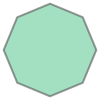

In [149]:
gdf['geometry'].buffer(0.01, resolution=2)[0]

In [150]:
centers = gdf['geometry'].tolist()
buffers = gdf['Price'].tolist()
new_polygons = []
for c, b in zip(centers, buffers):
    new_polygons.append(c.buffer(0.001, resolution=2))
gdf['Polygons'] = new_polygons

In [151]:
gdf.head()

,Name,Link,Vraagprijs,Vraagprijs per m²,Aangeboden sinds,Status,Aanvaarding,Bijdrage VvE,Soort appartement,Soort bouw,...,Postal Code Generic,PostalCode,Latitude,Longitude,Price,Sale type,Price per m2,Surface,geometry,Polygons
0,Talbotstraat 207,https://www.funda.nl/koop/amsterdam/appartemen...,€ 400.000 k.k.,€ 4.396,11 oktober 2019,Beschikbaar,In overleg,€ 128 per maand,Galerijflat (appartement),Bestaande bouw,...,1087,1087DM,52.35794,4.99516,400000,K.K.,4396,91,POINT (4.99516 52.35794),"POLYGON ((4.996160000000001 52.35794, 4.995867..."
1,Burgemeester Hogguerstraat 777,https://www.funda.nl/koop/amsterdam/appartemen...,€ 300.000 k.k.,€ 3.846,12 oktober 2019,Beschikbaar,In overleg,€ 172 per maand,Bovenwoning (appartement),Bestaande bouw,...,1064,1064EB,52.37250,4.83004,300000,K.K.,3846,78,POINT (4.83004 52.37250),"POLYGON ((4.831040000000001 52.3725, 4.8307471..."
2,Laing's Nekstraat 36 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 325.000 k.k.,€ 6.373,12 oktober 2019,Beschikbaar,In overleg,€ 106 per maand,Tussenverdieping (appartement),Bestaande bouw,...,1092,1092GX,52.35506,4.92386,325000,K.K.,6373,51,POINT (4.92386 52.35506),"POLYGON ((4.92486 52.35505999999999, 4.9245671..."
3,Laing's Nekstraat 40 I,https://www.funda.nl/koop/amsterdam/appartemen...,€ 315.000 k.k.,€ 6.300,6+ maanden,Verkocht onder voorbehoud,In overleg,€ 106 per maand,Portiekwoning (appartement),Bestaande bouw,...,1092,1092GX,52.35506,4.92386,315000,K.K.,6300,50,POINT (4.92386 52.35506),"POLYGON ((4.92486 52.35505999999999, 4.9245671..."
4,Hellenburg 11,https://www.funda.nl/koop/amsterdam/appartemen...,€ 375.000 k.k.,€ 4.688,11 oktober 2019,Beschikbaar,In overleg,€ 283 per maand,Bovenwoning (appartement),Bestaande bouw,...,1082,1082GP,52.32638,4.87948,375000,K.K.,4688,80,POINT (4.87948 52.32638),"POLYGON ((4.88048 52.32638, 4.880187106781187 ..."


In [152]:
gdf.set_geometry(col='Polygons', crs={'init': 'epsg:4326'}, inplace=True)

In [153]:
gdf.drop(labels=['geometry'], axis=1, inplace=True)

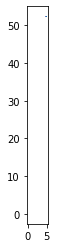

In [154]:
gdf.plot()

In [155]:
kepler_config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'gh29r5k',
     'type': 'geojson',
     'config': {'dataId': 'funda_data',
      'label': 'funda_data',
      'color': [255, 153, 31],
      'columns': {'geojson': 'Polygons'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [241, 92, 23],
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#006837',
         '#1a9850',
         '#66bd63',
         '#a6d96a',
         '#d9ef8b',
         '#fee08b',
         '#fdae61',
         '#f46d43',
         '#d73027',
         '#a50026'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 10,
       'stroked': True,
       'filled': True,
       'enable3d': True,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Price', 'type': 'integer'},
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': {'name': 'Price per m2', 'type': 'integer'},
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'funda_data': ['Name',
       'Link',
       'Vraagprijs',
       'Vraagprijs per m²',
       'Bouwjaar',
       'Aantal kamers',
       'Surface']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 12.990825688073397,
   'dragRotate': True,
   'latitude': 52.36793246276968,
   'longitude': 4.713965164240425,
   'pitch': 57.49685195279452,
   'zoom': 9.554748685343336,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [156]:
kepler_viz = keplergl.KeplerGl(height=800, data={'funda_data': gdf}, config=kepler_config)
kepler_viz

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'gh29r5k', 'type': …

In [42]:
kepler_config = kepler_viz.config
kepler_config

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'gh29r5k',
     'type': 'geojson',
     'config': {'dataId': 'funda_data',
      'label': 'funda_data',
      'color': [255, 153, 31],
      'columns': {'geojson': 'Polygons'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [241, 92, 23],
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#006837',
         '#1a9850',
         '#66bd63',
         '#a6d96a',
         '#d9ef8b',
         '#fee08b',
         '#fdae61',
         '#f46d43',
         '#d73027',
         '#a50026'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,

In [157]:
gdf.to_file('funda_data.geojson', driver='GeoJSON')